<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/Muting_Sparse_Neurons_SAE_dyn_left_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1erGvTo3VIy1c3rAL9vxMkEHfyLQ0M_Qg#scrollTo=gmYi78ByHxs0

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import torch
import numpy as np
import gc
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seed for reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [25]:
# Define the custom AlexNet model based from the older notebook
class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 1 * 1, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Load AlexNet Model
def load_model(model_path):
    print(f"Loading model from {model_path}")
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model

# Define Image Dataset and Preprocessing
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




In [26]:
# Define Sparse Autoencoder from older notebook
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(in_dims, h_dims), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(h_dims, in_dims), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the pre-trained autoencoder for layer 6 (fc2) (from snippet 4)
def load_autoencoder(device):
    save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/dynamic_left_patch/Autoencoders/autoencoder_layer_6.pth'
    input_dims = 4096
    encoding_dim = 8192
    autoencoder = SparseAutoencoder(input_dims, encoding_dim).to(device)
    autoencoder.load_state_dict(torch.load(save_sae_dir))
    autoencoder.eval()
    return autoencoder


In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import gc
import torch
from scipy.stats import ttest_ind
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Set up device for model computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure base directory paths are created
base_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"
activation_dir = os.path.join(base_dir, "activations")
output_base_dir = os.path.join(base_dir, "outputs")
Path(output_base_dir).mkdir(parents=True, exist_ok=True)

# Define paths for pre-saved activations
def get_activation_path(folder_name, filename):
    return os.path.join(activation_dir, folder_name, f"{filename}.npy")

# Extract activations for fc2 (layer 6)
def extract_fc2_activations(model, dataloader):
    print("Extracting Alexnet activations for layer fc2...")
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)
            tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            tensor = tensor.view(-1, 256 * 1 * 1)
            tensor = model.fc2(model.fc1(tensor))
            activations.append(tensor.cpu().numpy())
            print(f"Processed {len(activations)} images")
            torch.cuda.empty_cache()
            gc.collect()
    return np.vstack(activations)

# Function to load activations if they exist or extract and save them if not
def load_or_extract_fc2_activations(model, dataloader, folder_name, filename):
    activation_path = get_activation_path(folder_name, filename)
    if os.path.exists(activation_path):
        print(f"Loading pre-saved Alexnet activations for {filename} from {activation_path}...")
        activations = np.load(activation_path, allow_pickle=True)
    else:
        print(f"No pre-saved Alexnet activations found for {filename}. Extracting and saving...")
        activations = extract_fc2_activations(model, dataloader)
        os.makedirs(os.path.dirname(activation_path), exist_ok=True)
        np.save(activation_path, activations)
        print(f"Activations for layer fc2 saved to {activation_path}")
    return activations

# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Function 1: Calculate neuron activations per image and overall average for patched/unpatched sets
def calculate_neuron_activations(autoencoder, activations, folder_name, patch_status):
    print(f"Calculating neuron activations for {patch_status} images...")
    projected_activations = project_activations(autoencoder, activations, device)
    neuron_activations = pd.DataFrame(projected_activations)

    # Save individual activations per image
    individual_activation_path = os.path.join(folder_name, f"{patch_status}_individual_neuron_activations.csv")
    neuron_activations.to_csv(individual_activation_path, index=False)

    # Calculate and save the average activations across all images for each neuron
    neuron_avg = neuron_activations.mean(axis=0)
    avg_activation_path = os.path.join(folder_name, f"{patch_status}_average_neuron_activations.csv")
    neuron_avg.to_csv(avg_activation_path, header=["Average Activation"], index_label="Neuron")

    print(f"Saved {patch_status} individual activations to {individual_activation_path} and averages to {avg_activation_path}")
    return neuron_avg

# Function 2: Calculate the absolute difference in average activations between patched and unpatched
def calculate_neuron_differences(avg_activations_patch, avg_activations_no_patch, folder_name):
    print("Calculating absolute difference in activations...")
    abs_diff = np.abs(avg_activations_patch - avg_activations_no_patch)
    diff_path = os.path.join(folder_name, "neuron_absolute_differences.csv")
    abs_diff.to_csv(diff_path, header=["Absolute Difference"], index_label="Neuron")
    print(f"Saved neuron differences to {diff_path}")
    return abs_diff

# Function 3: Identify and save the top 10% neurons with the highest difference
def get_top_neurons(abs_diff, folder_name, top_percentage=0.1):
    top_neuron_count = int(len(abs_diff) * top_percentage)
    top_neurons = abs_diff.nlargest(top_neuron_count).index
    top_neuron_path = os.path.join(folder_name, "top_10_percent_neurons.csv")
    pd.DataFrame(top_neurons, columns=["Neuron"]).to_csv(top_neuron_path, index=False)
    print(f"Saved top 10% neurons with highest differences to {top_neuron_path}")
    return top_neurons

# Function 4: Mute the top neurons in sparse space and classify patched images
def classify_with_muted_neurons(autoencoder, model, activations_patch, top_neurons):
    print("Muting top neurons and classifying patched images...")
    projected_patch = project_activations(autoencoder, activations_patch, device)
    projected_patch[:, top_neurons] = 0  # Mute selected neurons
    decoded_patch = autoencoder.decoder(torch.from_numpy(projected_patch).to(device).float()).cpu().detach().numpy()

    # Pass through AlexNet softmax for classification
    predictions = []
    for activation in decoded_patch:
        output = model.fc3(torch.from_numpy(activation).float().to(device))
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions

# Function 5: Classify unmuted sparse activations for non-patched images
def classify_without_muting(autoencoder, model, activations_no_patch):
    print("Classifying non-patched images without muting neurons...")
    projected_no_patch = project_activations(autoencoder, activations_no_patch, device)
    decoded_no_patch = autoencoder.decoder(torch.from_numpy(projected_no_patch).to(device).float()).cpu().detach().numpy()

    # Classify with AlexNet softmax
    predictions = []
    for activation in decoded_no_patch:
        output = model.fc3(torch.from_numpy(activation).float().to(device))
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions

# Function 6: Save decoded neuron activations per image
def save_decoded_activations(decoded_activations, patch_status, folder_name):
    decoded_path = os.path.join(folder_name, f"decoded_activations_{patch_status}.csv")
    pd.DataFrame(decoded_activations).to_csv(decoded_path, index=False)
    print(f"Saved decoded neuron activations for {patch_status} images to {decoded_path}")

# Function 7: Save average neuron activations across all images
def save_average_activations(decoded_activations, patch_status, folder_name):
    avg_activations = np.mean(decoded_activations, axis=0)
    avg_path = os.path.join(folder_name, f"average_decoded_activations_{patch_status}.csv")
    pd.DataFrame(avg_activations, columns=["Average Activation"]).to_csv(avg_path, index_label="Neuron")
    print(f"Saved average decoded activations for {patch_status} images to {avg_path}")

# Function 8: Evaluate the effect of muting neurons
def evaluate_muting_effect(predictions_with_muting, predictions_without_muting):
    agreement_count = sum(pw == pn for pw, pn in zip(predictions_with_muting, predictions_without_muting))
    accuracy = agreement_count / len(predictions_with_muting) * 100
    print(f"Accuracy of classifications with muted neurons matching non-muted classifications: {accuracy:.2f}%")
    # print("Percentage change in classification accuracy after muting")

# Function 9: Calculate and display classification metrics
def evaluate_classification_metrics(predictions_with_muting, predictions_without_muting, labels):
    target_class = 1
    labels_target = [1 if label == target_class else 0 for label in labels]
    preds_with_muting_target = [1 if pred == target_class else 0 for pred in predictions_with_muting]
    preds_without_muting_target = [1 if pred == target_class else 0 for pred in predictions_without_muting]

    accuracy_with_muting = accuracy_score(labels_target, preds_with_muting_target)
    precision_with_muting = precision_score(labels_target, preds_with_muting_target)
    recall_with_muting = recall_score(labels_target, preds_with_muting_target)

    accuracy_without_muting = accuracy_score(labels_target, preds_without_muting_target)
    precision_without_muting = precision_score(labels_target, preds_without_muting_target)
    recall_without_muting = recall_score(labels_target, preds_without_muting_target)

    print("Metrics for 'two with patch' class with muting:")
    print(f"  Accuracy: {accuracy_with_muting:.2f}")
    print("\nMetrics for 'two with patch' class without muting:")
    print(f"  Accuracy: {accuracy_without_muting:.2f}")

# Function 10: Visualize differences for top neurons with binning
def visualize_binned_neuron_differences(abs_diff, top_neurons, bin_width=0.05):
    # Get the differences for the top neurons and sort them
    top_neuron_diffs = abs_diff.loc[top_neurons].sort_values(ascending=False)

    # Bin the difference values
    max_diff = top_neuron_diffs.max()
    bins = np.arange(0, max_diff + bin_width, bin_width)
    binned_counts = pd.cut(top_neuron_diffs, bins=bins).value_counts(sort=False)

    # Plot the binned counts
    plt.figure(figsize=(10, 6))
    binned_counts.plot(kind='bar', color='skyblue')
    plt.xlabel("Difference Value Bins")
    plt.ylabel("Neuron Count")
    plt.title("Neuron Count in Each Difference Value Bin")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')

    # Display grid for easier comparison
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Function 11: Conduct t-tests in sparse and decoded space
def t_test_sparse_vs_non_sparse(sparse_with_patch, sparse_no_patch):
    t_stat_sparse, p_value_sparse = ttest_ind(sparse_with_patch, sparse_no_patch, equal_var=False)
    print(f"Sparse Activations T-Test:\n  T-statistic: {t_stat_sparse}, P-value: {p_value_sparse}")
    return t_stat_sparse, p_value_sparse

def t_test_decoded_muted_vs_non_muted(decoded_with_patch_muted, decoded_with_patch_non_muted):
    t_stat_decoded, p_value_decoded = ttest_ind(decoded_with_patch_muted, decoded_with_patch_non_muted, equal_var=False)
    print(f"Decoded Activations T-Test:\n  T-statistic: {t_stat_decoded}, P-value: {p_value_decoded}")
    return t_stat_decoded, p_value_decoded

# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        output = model.fc3(torch.from_numpy(activation).float().to(device))
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions


# Function 13: Perform and print formatted t-tests for layer activations
def perform_and_format_t_tests(condition1_activations, condition2_activations, layer_name="Layer"):
    # Perform two-sample t-test
    t_stat, p_values = ttest_ind(condition1_activations, condition2_activations, axis=0, equal_var=False)

    # Bonferroni correction
    num_neurons = condition1_activations.shape[1]
    adjusted_p_values = np.minimum(p_values * num_neurons, 1.0)

    # Calculate mean activations for each neuron
    condition1_mean = np.mean(condition1_activations, axis=0)
    condition2_mean = np.mean(condition2_activations, axis=0)

    # Calculate and display the percentage of neurons with significant p-values
    raw_significant_0_05 = np.mean(p_values <= 0.05) * 100
    raw_significant_0_02 = np.mean(p_values <= 0.02) * 100
    corrected_significant_0_05 = np.mean(adjusted_p_values <= 0.05) * 100
    corrected_significant_0_02 = np.mean(adjusted_p_values <= 0.02) * 100

    print(f"{layer_name}:")
    print("  Condition 1 Mean Activation (Muted):")
    print(f"    Mean across neurons: {condition1_mean.mean():.4f}")
    print("  Condition 2 Mean Activation (Non-Muted):")
    print(f"    Mean across neurons: {condition2_mean.mean():.4f}")
    print("  T-Test (before Bonferroni correction):")
    print(f"    Percentage of neurons with raw p-value <= 0.05: {raw_significant_0_05:.2f}%")
    print(f"    Percentage of neurons with raw p-value <= 0.02: {raw_significant_0_02:.2f}%")
    print("  T-Test (after Bonferroni correction):")
    print(f"    Percentage of neurons with adjusted p-value <= 0.05: {corrected_significant_0_05:.2f}%")
    print(f"    Percentage of neurons with adjusted p-value <= 0.02: {corrected_significant_0_02:.2f}%")
    print("-" * 50)


Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_1train.pt


<ipython-input-25-f02631ea6dac>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded successfully


<ipython-input-26-ad49f019404b>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))


Loading pre-saved Alexnet activations for fc2_activations_patch from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/test_patch/fc2_activations_patch.npy...
Loading pre-saved Alexnet activations for fc2_activations_no_patch from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/test_no_patch/fc2_activations_no_patch.npy...
Calculating neuron activations for patch images...
Projecting Alexnet activations into SAE sparse space...
Saved patch individual activations to /content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/fc2_sparse_outputs/patch_individual_neuron_activations.csv and averages to /content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/fc2_sparse_outputs/patch_average_neuron_activations.csv
Calculating neuron activations for no_patch images...
Projecting Alexnet activations into SAE sparse space...
Saved no_patch individual activations to /content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/fc2_sparse_outputs/no_patch_individual_neur

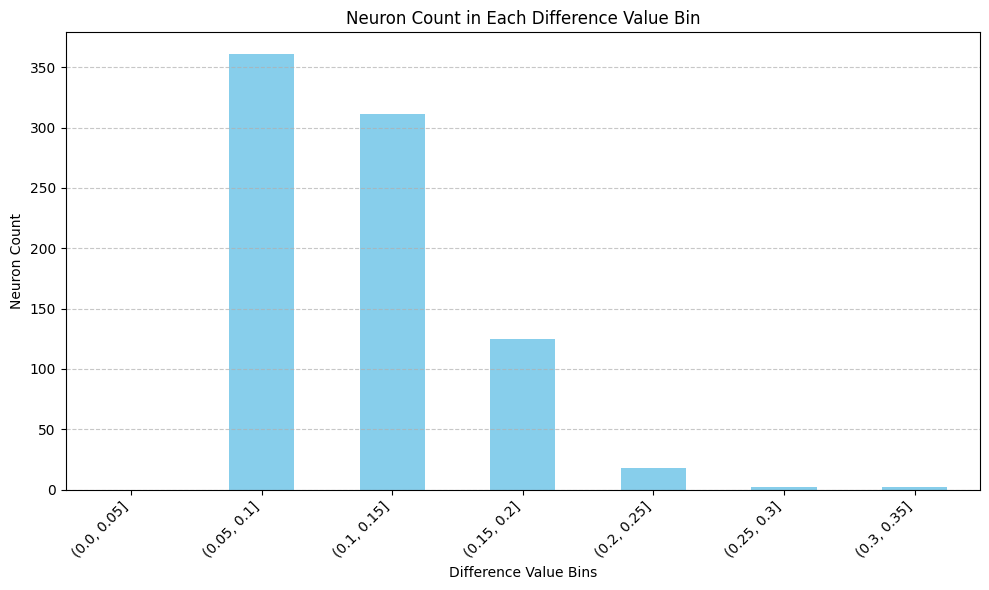

Muting top neurons and classifying patched images...
Projecting Alexnet activations into SAE sparse space...
Classifying non-patched images without muting neurons...
Projecting Alexnet activations into SAE sparse space...
Accuracy of classifications with muted neurons matching non-muted classifications: 27.91%
Metrics for 'two with patch' class with muting:
  Accuracy: 0.19

Metrics for 'two with patch' class without muting:
  Accuracy: 0.85
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Performing T-Tests on Sparse Activations:
Sparse Activations:
  Condition 1 Mean Activation (Muted):
    Mean across neurons: 0.6564
  Condition 2 Mean Activation (Non-Muted):
    Mean across neurons: 0.6785
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 78.88%
    Percentage of neurons with raw p-value <= 0.02: 75.26%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adju

In [28]:
# Main function
def main():
    # Paths and initialization
    model_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_1train.pt"
    patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2'
    no_patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

    # Load model and autoencoder
    model = load_model(model_path)
    autoencoder = load_autoencoder(device)

    # Prepare dataloaders
    patch_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(patch_folder) for file in files if file.endswith(('.jpg', '.png'))]
    no_patch_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(no_patch_folder) for file in files if file.endswith(('.jpg', '.png'))]

    patch_dataset = ImageDataset(patch_image_paths, transform=preprocess)
    no_patch_dataset = ImageDataset(no_patch_image_paths, transform=preprocess)

    patch_loader = DataLoader(patch_dataset, batch_size=1, shuffle=False)
    no_patch_loader = DataLoader(no_patch_dataset, batch_size=1, shuffle=False)

    # Load or extract fc2 activations
    activations_patch = load_or_extract_fc2_activations(model, patch_loader, 'test_patch', 'fc2_activations_patch')
    activations_no_patch = load_or_extract_fc2_activations(model, no_patch_loader, 'test_no_patch', 'fc2_activations_no_patch')

    # Directory for saving results
    sparse_output_dir = os.path.join(output_base_dir, "fc2_sparse_outputs")
    Path(sparse_output_dir).mkdir(parents=True, exist_ok=True)

    # Calculate activations and save outputs
    avg_activations_patch = calculate_neuron_activations(autoencoder, activations_patch, sparse_output_dir, "patch")
    avg_activations_no_patch = calculate_neuron_activations(autoencoder, activations_no_patch, sparse_output_dir, "no_patch")

    # Calculate differences and get top neurons
    abs_diff = calculate_neuron_differences(avg_activations_patch, avg_activations_no_patch, sparse_output_dir)
    top_neurons = get_top_neurons(abs_diff, sparse_output_dir)

    # Visualize top neuron differences
    visualize_binned_neuron_differences(abs_diff, top_neurons, bin_width=0.05)


    # Classify with and without muting, then evaluate
    predictions_with_muting = classify_with_muted_neurons(autoencoder, model, activations_patch, top_neurons)
    predictions_without_muting = classify_without_muting(autoencoder, model, activations_no_patch)
    evaluate_muting_effect(predictions_with_muting, predictions_without_muting)

    # Evaluate classification metrics
    labels = [1] * len(predictions_with_muting)  # All images are class 2
    evaluate_classification_metrics(predictions_with_muting, predictions_without_muting, labels)

    # Project into sparse space
    projected_patch = project_activations(autoencoder, activations_patch, device)
    projected_no_patch = project_activations(autoencoder, activations_no_patch, device)

    # Ensure we have decoded versions if needed for t-tests on decoded activations
    decoded_with_patch_muted = autoencoder.decoder(torch.from_numpy(projected_patch).to(device).float()).cpu().detach().numpy()
    decoded_with_patch_non_muted = autoencoder.decoder(torch.from_numpy(projected_no_patch).to(device).float()).cpu().detach().numpy()

    # Perform t-tests
    #t_stat_sparse, p_value_sparse = t_test_sparse_vs_non_sparse(projected_patch, projected_no_patch)
    #t_stat_decoded, p_value_decoded = t_test_decoded_muted_vs_non_muted(decoded_with_patch_muted, decoded_with_patch_non_muted)


    # Perform t-tests
    #t_stat_sparse, p_value_sparse = t_test_sparse_vs_non_sparse(projected_patch, projected_no_patch)
    #t_stat_decoded, p_value_decoded = t_test_decoded_muted_vs_non_muted(decoded_with_patch_muted, decoded_with_patch_non_muted)

    # Decode both conditions for comparisons in decoded space
    decoded_patch_muted = autoencoder.decoder(torch.from_numpy(projected_patch).to(device).float()).cpu().detach().numpy()
    decoded_patch_non_muted = autoencoder.decoder(torch.from_numpy(projected_no_patch).to(device).float()).cpu().detach().numpy()

    # Perform t-tests on sparse activations
    print("Performing T-Tests on Sparse Activations:")
    perform_and_format_t_tests(projected_patch, projected_no_patch, layer_name="Sparse Activations")

    # Perform t-tests on decoded activations
    print("Performing T-Tests on Decoded Activations (Muted vs Non-Muted):")
    perform_and_format_t_tests(decoded_with_patch_muted, decoded_with_patch_non_muted, layer_name="Decoded Activations")

    # Classify decoded activations for images with no patch in sparse space
    print("\nClassifying decoded activations for 'two with no patch' after projecting into sparse space and decoding...")
    predictions_no_patch_decoded = classify_decoded_activations(model, decoded_patch_non_muted)

    # Calculate and print accuracy for 'two with no patch' decoded activations
    labels_no_patch = [1] * len(predictions_no_patch_decoded)  # All images are labeled as class 2
    accuracy_no_patch_decoded = accuracy_score(labels_no_patch, predictions_no_patch_decoded)
    print(f"Accuracy of 'two with no patch' decoded activations after sparse projection: {accuracy_no_patch_decoded:.2f}")





main()


**Something to think about when using laster a larget sparse space...now I only have 8k neurons in the sparse space:**

In the sparse space, not all neurons are consistently activated across all images. For example, a neuron might remain inactive (close to zero) in most images, but activate strongly for a few specific images, such as those containing spurious features like patches. When we take the average activation of that neuron across all images, the low values from the inactive images will dominate, resulting in a low overall average. This averaging process can therefore obscure the true impact of that neuron in encoding the patch feature, leading to a misleadingly low indication of its importance. The concern is that by using the average activation values in this way, we might be overlooking neurons that are actually sensitive to the spurious features but appear unimportant due to their sparsity. This could affect the accuracy of our results, particularly in identifying which neurons are encoding spurious features.

In [32]:
stophere

NameError: name 'stophere' is not defined

# Archives

In [ ]:
# Define paths to Google Drive locations for pre-saved activations
def get_activation_path(folder_name, filename):
    return f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}.npy'


# Extract activations for fc2 (layer 6)
def extract_fc2_activations(model, dataloader):
    print("Extracting Alexnet activations for layer fc2...")
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)
            tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            tensor = tensor.view(-1, 256 * 1 * 1)
            tensor = model.fc2(model.fc1(tensor))
            activations.append(tensor.cpu().numpy())
            print(f"Processed {len(activations)} images")
            torch.cuda.empty_cache()
            gc.collect()
    return np.vstack(activations)


# Function to load activations if they exist or extract and save them if not
def load_or_extract_fc2_activations(model, dataloader, folder_name, filename):
    activation_path = get_activation_path(folder_name, filename)

    # Check if the activation file already exists
    if os.path.exists(activation_path):
        print(f"Loading pre-saved Alexnet activations for {filename} from {activation_path}...")
        activations = np.load(activation_path, allow_pickle=True)
    else:
        print(f"No pre-saved Alexnet activations found for {filename}. Extracting and saving...")
        activations = extract_fc2_activations(model, dataloader)
        os.makedirs(os.path.dirname(activation_path), exist_ok=True)
        np.save(activation_path, activations)
        print(f"Activations for layer fc2 saved to {activation_path}")

    return activations


# Extract and save activations for fc2 (layer 6) to Google Drive
def extract_and_save_fc2_activations(model, dataloader, folder_name, filename):
    print("Extracting and saving Alexnet activations for layer fc2...")
    # Extract activations using the existing function
    activations = extract_fc2_activations(model, dataloader)

    # Define the save path in Google Drive
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}.npy'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)

    # Save the activations as a .npy file
    np.save(drive_path, activations)
    print(f"Alexnet Activations for layer fc2 saved to {drive_path}")

# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Mean Activation Difference
def mean_activation_difference(projected_patch, projected_no_patch, top_k=10):
    print("Calculating mean sparse activations difference...")
    mean_diff = np.abs(projected_patch.mean(axis=0) - projected_no_patch.mean(axis=0))
    top_neurons = np.argsort(mean_diff)[-top_k:]
    return top_neurons

# Statistical Significance Testing
def statistical_testing_neurons(projected_patch, projected_no_patch, threshold=0.05):
    print("Performing statistical testing...")
    significant_neurons = []
    for i in range(projected_patch.shape[1]):
        _, p_value = ttest_ind(projected_patch[:, i], projected_no_patch[:, i], equal_var=False)
        if p_value < threshold:
            significant_neurons.append(i)
    return significant_neurons

# Use AlexNet's own FC weights to identify patch-relevant neurons
def patch_classifier_importance(model, projected_patch, projected_no_patch, top_k=10):
    print("Using AlexNet's FC layer weights to identify important neurons...")
    # Extract weights from the final fully connected layer (fc3 as output)
    importance = np.abs(model.fc3.weight.cpu().detach().numpy()[0])  # Take absolute values of weights

    # Sort by importance and get the top K neurons
    top_neurons = np.argsort(importance)[-top_k:]
    print("Top neurons identified based on AlexNet's weights:", top_neurons)
    return top_neurons


# Correlation Analysis
def correlation_analysis(projected_patch, projected_no_patch, top_k=10):
    combined = np.vstack([projected_patch, projected_no_patch])
    patch_condition = np.hstack([np.ones(len(projected_patch)), np.zeros(len(projected_no_patch))])
    correlations = [pearsonr(combined[:, i], patch_condition)[0] for i in range(combined.shape[1])]
    top_neurons = np.argsort(np.abs(correlations))[-top_k:]
    return top_neurons

# Visualize Top Neurons
def visualize_neurons(neuron_indexes_dict):
    # Convert neuron indexes to a DataFrame, filling missing values with NaN
    neuron_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in neuron_indexes_dict.items()]))

    # Plot each method's top neuron indexes using a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(neuron_df, annot=True, fmt=".0f", cmap="viridis",  # Use .0f to handle NaN values
                cbar=True, yticklabels=False)

    plt.xlabel("Methods")
    plt.ylabel("Top Neurons")
    plt.title("Comparison of Silenced Neurons Across Methods")
    plt.show()


def silence_and_classify(autoencoder, model, activations_patch, selected_neurons):
    projected_patch = project_activations(autoencoder, activations_patch, device)
    silenced_patch = np.copy(projected_patch)
    silenced_patch[:, selected_neurons] = 0
    decoded_patch = autoencoder.decoder(torch.from_numpy(silenced_patch).to(device).float()).detach().cpu().numpy()

    # Decode and classify with AlexNet softmax
    predictions = []
    for decoded_activation in decoded_patch:
        decoded_tensor = torch.from_numpy(decoded_activation).float().to(device)
        output = model.fc3(decoded_tensor)  # After fc2, apply fc3 for classification
        prediction = torch.argmax(F.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions


# Helper function to calculate accuracy
def calculate_accuracy(predictions, labels):
    correct = sum([1 if pred == label else 0 for pred, label in zip(predictions, labels)])
    return correct / len(labels) * 100  # Returns accuracy percentage

# Check overlap in silenced neurons across methods
def check_neuron_overlap(silenced_neurons_dict):
    methods = list(silenced_neurons_dict.keys())
    overlap_counts = {}

    for i, method1 in enumerate(methods):
        for method2 in methods[i + 1:]:
            overlap = set(silenced_neurons_dict[method1]).intersection(silenced_neurons_dict[method2])
            overlap_counts[f"{method1} & {method2}"] = len(overlap)

    print("Neuron Overlap Across Methods:")
    for pair, count in overlap_counts.items():
        print(f"{pair}: {count} neurons")




In [ ]:
# Directory path for saving outputs
output_dir = Path("/content/drive/MyDrive/Masterthesis/Datasets/mnist/muted_sparse_sae/outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Main function for all methods
def main():
    # Paths and initialization
    model_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_1train.pt"
    patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2'
    no_patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

    # Load model and autoencoder
    model = load_model(model_path)
    autoencoder = load_autoencoder(device)

    # Prepare dataloaders for patched and unpatched datasets
    patch_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(patch_folder) for file in files if file.endswith(('.jpg', '.png'))]
    no_patch_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(no_patch_folder) for file in files if file.endswith(('.jpg', '.png'))]

    patch_dataset = ImageDataset(patch_image_paths, transform=preprocess)
    no_patch_dataset = ImageDataset(no_patch_image_paths, transform=preprocess)

    patch_loader = DataLoader(patch_dataset, batch_size=1, shuffle=False)
    no_patch_loader = DataLoader(no_patch_dataset, batch_size=1, shuffle=False)

    # Conditionally load or extract activations for patched images
    activations_patch = load_or_extract_fc2_activations(model, patch_loader, 'test_patch', 'fc2_activations_patch')

    # Conditionally load or extract activations for non-patched images
    activations_no_patch = load_or_extract_fc2_activations(model, no_patch_loader, 'test_no_patch', 'fc2_activations_no_patch')

    # Project into sparse space
    projected_patch = project_activations(autoencoder, activations_patch, device)
    projected_no_patch = project_activations(autoencoder, activations_no_patch, device)

    # Dictionary to store neuron indexes for each method
    silenced_neurons_dict = {}

    # Method 1: Mean Activation Difference
    top_neurons_mean_diff = mean_activation_difference(projected_patch, projected_no_patch, top_k=10)
    silenced_neurons_dict["Mean Activation Diff"] = top_neurons_mean_diff
    predictions_mean_diff = silence_and_classify(autoencoder, model, activations_patch, top_neurons_mean_diff)
    print("Classification Results (Mean Activation Diff):")
    print(predictions_mean_diff)

    # Method 2: Statistical Testing
    top_neurons_stat_test = statistical_testing_neurons(projected_patch, projected_no_patch, threshold=0.05)
    silenced_neurons_dict["Statistical Test"] = top_neurons_stat_test
    predictions_stat_test = silence_and_classify(autoencoder, model, activations_patch, top_neurons_stat_test)
    print("Classification Results (Statistical Test):")
    print(predictions_stat_test)

    # Method 3: Patch Classifier (Using AlexNet's FC Layer Weights)
    top_neurons_classifier = patch_classifier_importance(model, projected_patch, projected_no_patch, top_k=10)
    silenced_neurons_dict["Patch Classifier"] = top_neurons_classifier
    predictions_classifier = silence_and_classify(autoencoder, model, activations_patch, top_neurons_classifier)
    print("Classification Results (Patch Classifier):")
    print(predictions_classifier)

    # Method 4: Correlation Analysis
    top_neurons_correlation = correlation_analysis(projected_patch, projected_no_patch, top_k=10)
    silenced_neurons_dict["Correlation Analysis"] = top_neurons_correlation
    predictions_correlation = silence_and_classify(autoencoder, model, activations_patch, top_neurons_correlation)
    print("Classification Results (Correlation Analysis):")
    print(predictions_correlation)

    # Print silenced neurons by each method
    print("Silenced neurons by each method:", silenced_neurons_dict)

    # Check neuron overlap across methods
    check_neuron_overlap(silenced_neurons_dict)

    # Visualize silenced neuron indexes
    visualize_neurons(silenced_neurons_dict)

# Execute main function
main()
